In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt


################################################################################

# create a model object from the keypointrcnn_resnet50_fpn class
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
# call the eval() method to prepare the model for inference mode.
model.eval()


# create the list of keypoints.
keypoints = ['nose','left_eye','right_eye','left_ear','right_ear','left_shoulder','right_shoulder','left_elbow',
                'right_elbow','left_wrist','right_wrist','left_hip','right_hip','left_knee', 'right_knee', 'left_ankle','right_ankle']


###############################################################################


# import the transforms module
from torchvision import transforms as T

# Read the image using opencv
img_path = '/content/drive/MyDrive/PyTorch-Keypoint-RCNN/images/image_1.jpg'
img = cv2.imread(img_path)

# preprocess the input image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)

# forward-pass the model
# the input is a list, hence the output will also be a list
output = model([img_tensor])[0]


####################################################################################

def draw_keypoints_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # pick a set of N color-ids from the spectrum
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    # iterate for every person detected
    for person_id in range(len(all_keypoints)):
      # check the confidence score of the detected person
      if confs[person_id]>conf_threshold:
        # grab the keypoint-locations for the detected person
        keypoints = all_keypoints[person_id, ...]
        # grab the keypoint-scores for the keypoints
        scores = all_scores[person_id, ...]
        # iterate for every keypoint-score
        for kp in range(len(scores)):
            # check the confidence score of detected keypoint
            if scores[kp]>keypoint_threshold:
                # convert the keypoint float-array to a python-list of intergers
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                # pick the color at the specific color-id
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                # draw a cirle over the keypoint location
                cv2.circle(img_copy, keypoint, 30, color, -1)

    return img_copy



####################################################################################

def get_limbs_from_keypoints(keypoints):
  limbs = [
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
        ]
  return limbs


limbs = get_limbs_from_keypoints(keypoints)

###################################################################################


def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):

    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # check if the keypoints are detected
    if len(output["keypoints"])>0:
      # pick a set of N color-ids from the spectrum
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      # iterate for every person detected
      for person_id in range(len(all_keypoints)):
          # check the confidence score of the detected person
          if confs[person_id]>conf_threshold:
            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]

            # iterate for every limb
            for limb_id in range(len(limbs)):
              # pick the start-point of the limb
              limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
              # pick the start-point of the limb
              limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
              # consider limb-confidence score as the minimum keypoint score among the two keypoint scores
              limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
              # check if limb-score is greater than threshold
              if limb_score> keypoint_threshold:
                # pick the color at a specific color-id
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                # draw the line for the limb
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 25)

    return img_copy



keypoints_img = draw_keypoints_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)
cv2.imwrite("output/keypoints-img.jpg", keypoints_img)


skeletal_img = draw_skeleton_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)
cv2.imwrite("output/skeleton-img.jpg", skeletal_img)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:03<00:00, 65.3MB/s]


False

In [ ]:
import torchvision
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  os.makedirs("images")
  !wget -P images https://raw.githubusercontent.com/spmallick/learnopencv/master/PyTorch-Keypoint-RCNN/images/image_1.jpg
else:
  print('Not running on CoLab')

Running on CoLab
--2024-05-28 08:24:45--  https://raw.githubusercontent.com/spmallick/learnopencv/master/PyTorch-Keypoint-RCNN/images/image_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956658 (1.9M) [image/jpeg]
Saving to: ‘images/image_1.jpg’

image_1.jpg         100%[===================>]   1.87M  --.-KB/s    in 0.03s   

2024-05-28 08:24:45 (70.9 MB/s) - ‘images/image_1.jpg’ saved [1956658/1956658]



In [ ]:
# create a model object from the keypointrcnn_resnet50_fpn class
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
# call the eval() method to prepare the model for inference mode.
model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [ ]:
# create the list of keypoints.
keypoints = ['nose','left_eye','right_eye','left_ear','right_ear','left_shoulder','right_shoulder','left_elbow',
                'right_elbow','left_wrist','right_wrist','left_hip','right_hip','left_knee', 'right_knee', 'left_ankle','right_ankle']


print(keypoints)

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


In [ ]:
# get the limbs
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
        ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints)


In [ ]:
# import the transforms module
from torchvision import transforms as T

# Read the image using opencv
img_path = "./images/image_1.jpg"
img = cv2.imread(img_path)

# preprocess the input image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)

# forward-pass the model
# the input is a list, hence the output will also be a list
output = model([img_tensor])[0]

print(output.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


In [ ]:
def draw_keypoints_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # pick a set of N color-ids from the spectrum
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    # iterate for every person detected
    for person_id in range(len(all_keypoints)):
      # check the confidence score of the detected person
      if confs[person_id]>conf_threshold:
        # grab the keypoint-locations for the detected person
        keypoints = all_keypoints[person_id, ...]
        # grab the keypoint-scores for the keypoints
        scores = all_scores[person_id, ...]
        # iterate for every keypoint-score
        for kp in range(len(scores)):
            # check the confidence score of detected keypoint
            if scores[kp]>keypoint_threshold:
                # convert the keypoint float-array to a python-list of intergers
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                # pick the color at the specific color-id
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                # draw a cirle over the keypoint location
                cv2.circle(img_copy, keypoint, 30, color, -1)

    return img_copy



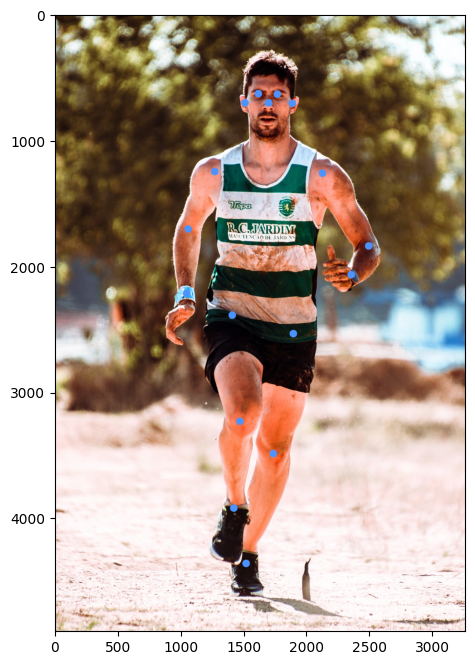

In [ ]:
keypoints_img = draw_keypoints_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)

cv2.imwrite("output/keypoints-img.jpg", keypoints_img)

plt.figure(figsize=(8, 8))
plt.imshow(keypoints_img[:, :, ::-1])
plt.show()

In [ ]:
def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):

    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # check if the keypoints are detected
    if len(output["keypoints"])>0:
      # pick a set of N color-ids from the spectrum
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      # iterate for every person detected
      for person_id in range(len(all_keypoints)):
          # check the confidence score of the detected person
          if confs[person_id]>conf_threshold:
            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]

            # iterate for every limb
            for limb_id in range(len(limbs)):
              # pick the start-point of the limb
              limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
              # pick the start-point of the limb
              limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
              # consider limb-confidence score as the minimum keypoint score among the two keypoint scores
              limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
              # check if limb-score is greater than threshold
              if limb_score> keypoint_threshold:
                # pick the color at a specific color-id
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                # draw the line for the limb
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 25)

    return img_copy

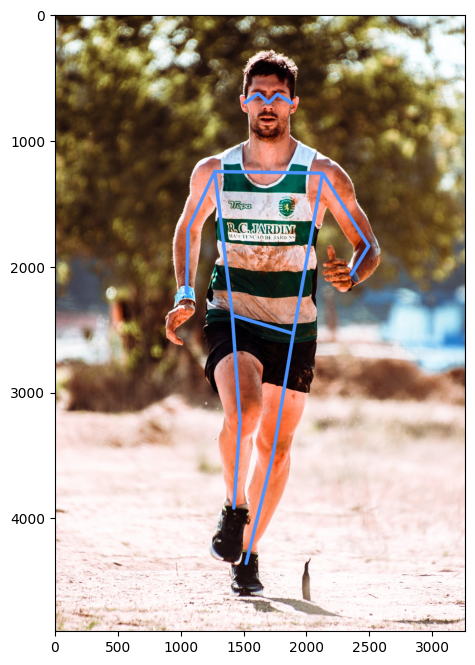

In [13]:
skeleton_img = draw_skeleton_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)

cv2.imwrite("output/skeleton-img.jpg", skeleton_img)

plt.figure(figsize=(8, 8))
plt.imshow(skeleton_img[:, :, ::-1])
plt.show()